In [ ]:
input_file = ""
output_dir = "./timesteps_modified/"  # Directory to store the output files

import os

os.makedirs(output_dir, exist_ok=True)

with open(input_file, "r") as infile:
    write_flag = False
    timestep = None
    num_atoms = 0
    atom_count = 0
    box_bounds = None
    outfile = None

    for line in infile:
        if line.startswith("ITEM: TIMESTEP"):
            if outfile:
                print("Closed file: ", outfile.name)
                outfile.close()
            timestep = int(next(infile).strip())
        elif line.startswith("ITEM: NUMBER OF ATOMS"):
            num_atoms = int(next(infile).strip())
        elif line.startswith("ITEM: BOX BOUNDS"):
            # Read the next 3 lines for box bounds
            box_bounds_lines = [next(infile).strip() for _ in range(3)]
            # Format box bounds for filename
            box_bounds = "_".join(
                [f"{float(line.split()[0]):.8f}_{float(line.split()[1]):.8f}" for line in box_bounds_lines]
            )
        elif line.startswith("ITEM: ATOMS"):
            write_flag = True
            headers = line.split()[2:]
            if timestep is not None and box_bounds is not None:
                # Create the output filename with corrected formatting
                output_file = os.path.join(
                    output_dir, f"timestep_{timestep}_{box_bounds}.csv"
                )
                outfile = open(output_file, "w")
            outfile.write(",".join(headers) + "\n")
            atom_count = 0
        elif line.startswith("ITEM:") and write_flag:
            write_flag = False
        elif write_flag:
            if atom_count < num_atoms:
                outfile.write(",".join(line.split()) + "\n")
                atom_count += 1

    if outfile:
        outfile.close()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
from scipy.optimize import curve_fit as cf
print('imported')


In [ ]:
def calculate_pairwise_distances(positions, lx, ly, lz):
    dx = positions[:, np.newaxis, 0] - positions[np.newaxis, :, 0]
    dy = positions[:, np.newaxis, 1] - positions[np.newaxis, :, 1]
    dz = positions[:, np.newaxis, 2] - positions[np.newaxis, :, 2]
    
    dx = dx - np.round(dx / lx) * lx
    dy = dy - np.round(dy / ly) * ly
    dz = dz - np.round(dz / lz) * lz
    
    squared_distances = dx**2 + dy**2 + dz**2
    distances = np.sqrt(squared_distances)
    
    return distances


In [6]:
import os
import numpy as np
import pandas as pd
import glob

# You must define this function or import it
def calculate_pairwise_distances(positions, lx, ly, lz):
    """
    Periodic boundary condition (PBC) pairwise distance calculation.
    Assumes positions is (N,3) array.
    """
    from scipy.spatial.distance import cdist

    delta = cdist(positions, positions)
    return delta

file_dir = "timesteps_modified"
file_pref = "timestep_"
file_suf = ".csv"
sti = 1000000
inc = 100000
cnt = 10000
batch_count = 1

rdf_batch = []
rdf_rho = []

while cnt > 0:
    file_pattern = os.path.join(file_dir, f"{file_pref}{sti}_*{file_suf}")
    matching_files = glob.glob(file_pattern)
    
    if not matching_files:
        print(f"No matching files found for pattern: {file_pattern}")
        break

    file_path = matching_files[0]
    filename = os.path.basename(file_path)
    parts = filename.split("_")

    x_bounds = (float(parts[2]), float(parts[3]))
    y_bounds = (float(parts[4]), float(parts[5]))
    z_bounds = (float(parts[6][:-4]), float(parts[7][:-4]))

    lx = (x_bounds[1] - x_bounds[0])
    ly = (y_bounds[1] - y_bounds[0])
    lz = (z_bounds[1] - z_bounds[0])
    volume = lx * ly * lz

    data = pd.read_csv(file_path)
    print("Frame: ", sti, '; Batch: ', batch_count)
    f1 = data
    f1.rename(columns={"id": "atom_id", "mol": "mol_id"}, inplace=True)
    f1.reset_index(drop=True, inplace=True)

    # Type 3 and Type 4 selection
    f1_3 = f1[f1['type'] == 5].copy()
    f1_4 = f1[f1['type'] == 6].copy()

    # COM for type 3 (can be type 4 too depending on need)
    com_x = f1_3['x'].mean()
    com_y = f1_3['y'].mean()
    com_z = f1_3['z'].mean()
    com = (com_x, com_y, com_z)

    # Center both selections
    for f in [f1_3, f1_4]:
        f['x'] -= com[0]
        f['y'] -= com[1]
        f['z'] -= com[2]

    # Position arrays
    pos_3 = f1_3[['x', 'y', 'z']].to_numpy()
    pos_4 = f1_4[['x', 'y', 'z']].to_numpy()

    # Cross-distance matrix (3 vs 4)
    from scipy.spatial.distance import cdist
    distance_matrix = cdist(pos_3, pos_4)

    N = f1_3.shape[0]
    rho = f1_4.shape[0] / volume  # cross-RDF: density of type 4

    cut_distance = 40
    distance_matrix_cut = []
    for i in distance_matrix:
        a_cut = [j for j in i if ((j < cut_distance) and (j > 0))]
        distance_matrix_cut.append(a_cut)

    number_density_all = []
    thickness = 0.3
    bins = np.arange(0, cut_distance + thickness, thickness)

    for i in distance_matrix_cut:
        counts, edges = np.histogram(i, bins=bins)
        shell_vol = (4 / 3) * np.pi * (edges[1:]**3 - edges[:-1]**3)
        number_density_rdf = counts / (shell_vol * rho)
        number_density_all.append(number_density_rdf)

    rdf_single = np.array(number_density_all)
    rdf_single = np.nan_to_num(rdf_single)
    rdf = np.mean(rdf_single, axis=0)
    
    rdf_batch.append(rdf)
    rdf_rho.append(rho)

    print("Volume:", volume)
    sti += inc
    cnt -= 1
    batch_count += 1


Frame:  1000000 ; Batch:  1
Volume: 504604.27789976716
Frame:  1100000 ; Batch:  2
Volume: 503122.2142168767
Frame:  1200000 ; Batch:  3
Volume: 501648.01768703683
Frame:  1300000 ; Batch:  4
Volume: 503633.8603577745
Frame:  1400000 ; Batch:  5
Volume: 505865.69964336767
Frame:  1500000 ; Batch:  6
Volume: 505435.90121020423
Frame:  1600000 ; Batch:  7
Volume: 504670.7994873506
Frame:  1700000 ; Batch:  8
Volume: 504918.52739208244
Frame:  1800000 ; Batch:  9
Volume: 503318.4199469656
Frame:  1900000 ; Batch:  10
Volume: 505602.7388303283
Frame:  2000000 ; Batch:  11
Volume: 503330.57633689273
Frame:  2100000 ; Batch:  12
Volume: 504405.80419802864
Frame:  2200000 ; Batch:  13
Volume: 504006.9622391199
Frame:  2300000 ; Batch:  14
Volume: 505720.6350417692
Frame:  2400000 ; Batch:  15
Volume: 503804.54774990433
Frame:  2500000 ; Batch:  16
Volume: 502289.8924035231
No matching files found for pattern: timesteps_modified/timestep_2600000_*.csv


In [7]:
rdf_batch = np.array(rdf_batch)
rdf_batch_mean = np.mean(rdf_batch, axis = 0)

In [8]:
dr = thickness
rdf_batch = np.array(rdf_batch)
r_vals = np.linspace(dr/2, dr * rdf_batch.shape[1] - dr/2, rdf_batch.shape[1])
rdf_batch_mean = np.mean(rdf_batch, axis=0)
np.savetxt(f"rdf_output_ctab_1.dat", np.column_stack((r_vals, rdf_batch_mean)), header="r g(r)", comments='')

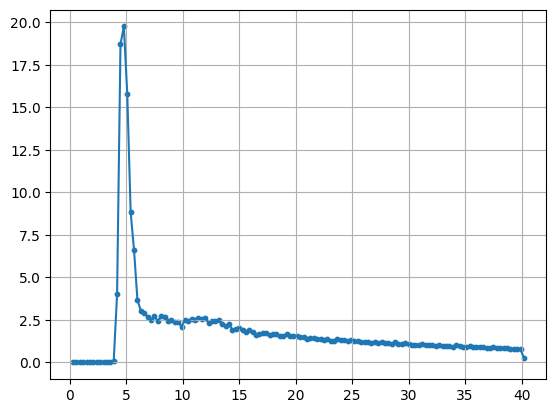

In [9]:
import matplotlib.pyplot as plt
#from scipy.ndimage import gaussian_filter1d
#rdf_smooth = gaussian_filter1d(rdf_batch_mean, sigma=0.9)

plt.plot(edges[1:], rdf_batch_mean)
plt.scatter(edges[1:], rdf_batch_mean, s=10)
plt.grid()
plt.show()


In [10]:
dr = edges[2] - edges[1]
batch_rdf_safe = np.where(rdf_batch_mean > 0, rdf_batch_mean, 1e-10)
integrand = (batch_rdf_safe*np.log(batch_rdf_safe) - (rdf_batch_mean - 1))*(edges[1:]**2)
ex = -2*np.pi* np.sum(rho*integrand*dr)

In [11]:
ex

np.float64(-2.7821944886757612)

In [5]:
import os
import numpy as np
import pandas as pd
import glob
from scipy.spatial.distance import cdist

# --- PARAMETERS ---
file_dir = "timesteps_modified"
file_pref = "timestep_"
file_suf = ".csv"
sti = 1000000    # start timestep
inc = 100000     # increment
cnt = 10         # number of frames
batch_count = 1

cut_distance = 20    # max RDF distance
thickness = 0.3      # bin width in sigma/units

rdf_batch = []
rdf_rho = []

while cnt > 0:
    file_pattern = os.path.join(file_dir, f"{file_pref}{sti}_*{file_suf}")
    matching_files = glob.glob(file_pattern)
    
    if not matching_files:
        print(f"No matching files found for pattern: {file_pattern}")
        break

    file_path = matching_files[0]
    filename = os.path.basename(file_path)
    parts = filename.split("_")

    x_bounds = (float(parts[2]), float(parts[3]))
    y_bounds = (float(parts[4]), float(parts[5]))
    z_bounds = (float(parts[6][:-4]), float(parts[7][:-4]))  # may still exist in filename

    lx = x_bounds[1] - x_bounds[0]
    ly = y_bounds[1] - y_bounds[0]
    area = lx * ly   # 2D area

    # --- Load data ---
    data = pd.read_csv(file_path)
    print("Frame: ", sti, '; Batch: ', batch_count)
    f1 = data.rename(columns={"id": "atom_id", "mol": "mol_id"}).reset_index(drop=True)

    # --- Select particle types (change numbers if needed) ---
    f1_3 = f1[f1['type'] == 5].copy()
    f1_4 = f1[f1['type'] == 6].copy()

    # --- Centering based on COM of type 3 ---
    com_x = f1_3['x'].mean()
    com_y = f1_3['y'].mean()
    com = (com_x, com_y)

    for f in [f1_3, f1_4]:
        f['x'] -= com[0]
        f['y'] -= com[1]

    # --- Extract positions (2D) ---
    pos_3 = f1_3[['x', 'y']].to_numpy()
    pos_4 = f1_4[['x', 'y']].to_numpy()

    # --- Distance matrix (2D) ---
    distance_matrix = cdist(pos_3, pos_4)

    N = f1_3.shape[0]
    rho = f1_4.shape[0] / area  # 2D density of type 4

    # --- Cutoff filtering ---
    distance_matrix_cut = []
    for row in distance_matrix:
        filtered = [d for d in row if (0 < d < cut_distance)]
        distance_matrix_cut.append(filtered)

    # --- Bin edges (2D) ---
    bins = np.arange(0, cut_distance + thickness, thickness)
    number_density_all = []

    for row in distance_matrix_cut:
        counts, edges = np.histogram(row, bins=bins)

        # 2D annulus area for normalization
        shell_area = np.pi * (edges[1:]**2 - edges[:-1]**2)

        # RDF normalization: g(r) = counts / (shell_area * rho)
        number_density_rdf = counts / (shell_area * rho)
        number_density_all.append(number_density_rdf)
 
    rdf_single = np.array(number_density_all)
    rdf_single = np.nan_to_num(rdf_single)
    rdf = np.mean(rdf_single, axis=0)
    
    rdf_batch.append(rdf)
    rdf_rho.append(rho)

    print("Area:", area)
    sti += inc
    cnt -= 1
    batch_count += 1

# rdf_batch now holds RDF arrays for each processed frame


Frame:  1000000 ; Batch:  1
Area: 6338.223992282035
Frame:  1100000 ; Batch:  2
Area: 6325.806703073384
Frame:  1200000 ; Batch:  3
Area: 6313.445195253907
Frame:  1300000 ; Batch:  4
Area: 6330.09308965925
Frame:  1400000 ; Batch:  5
Area: 6348.778864728935
Frame:  1500000 ; Batch:  6
Area: 6345.183163728963
Frame:  1600000 ; Batch:  7
Area: 6338.777782600185
Frame:  1700000 ; Batch:  8
Area: 6340.852753665566
Frame:  1800000 ; Batch:  9
Area: 6327.449218920143
Frame:  1900000 ; Batch:  10
Area: 6346.5782324040265


In [9]:
rdf_batch = np.array(rdf_batch)
rdf_batch_mean = np.mean(rdf_batch, axis = 0)

In [10]:
dr = thickness
rdf_batch = np.array(rdf_batch)
r_vals = np.linspace(dr/2, dr * rdf_batch.shape[1] - dr/2, rdf_batch.shape[1])
rdf_batch_mean = np.mean(rdf_batch, axis=0)
np.savetxt(f"rdf_output_ctab_2D.dat", np.column_stack((r_vals, rdf_batch_mean)), header="r g(r)", comments='')

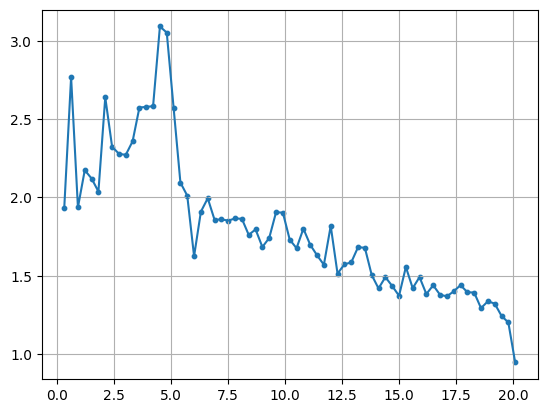

In [12]:
import matplotlib.pyplot as plt
#from scipy.ndimage import gaussian_filter1d
#rdf_smooth = gaussian_filter1d(rdf_batch_mean, sigma=0.9)

plt.plot(edges[1:], rdf_batch_mean)
plt.scatter(edges[1:], rdf_batch_mean, s=10)
plt.grid()
plt.show()
